In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import time
pd.set_option('mode.chained_assignment', None)

In [139]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import math
from scipy.stats import skew
from scipy.stats import boxcox
from scipy.stats import yeojohnson

In [180]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [182]:
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss

In [212]:
from imblearn.over_sampling import SMOTE

In [45]:
# function for converting '-' values to numbers
# col_k : 'k_temp' or col_k : 'k_rain'
def col_k_dash_remover(df, col_k):
    if len(df) != 0:
        cnt = 0
        for i in range(len(df)):
            # Num_rows : 1
            if len(df) == 1 and '-' in df[col_k].iloc[i]:
                df[col_k].iloc[i] = 0
            # Num_rows : 2
            if len(df) == 2 and i == 0:
                if '-' in df[col_k].iloc[i] and '-' not in df[col_k].iloc[i+1]:
                    df[col_k].iloc[i] = df[col_k].iloc[i+1]
                elif '-' not in df[col_k].iloc[i] and '-' in df[col_k].iloc[i+1]:    
                    df[col_k].iloc[i+1] = df[col_k].iloc[i]
                elif '-' in df[col_k].iloc[i] and '-' in df[col_k].iloc[i+1]:
                    df[col_k].iloc[i] = 0
                    df[col_k].iloc[i+1] = 0
            # ----------------------------------------------------------------------------------
            # Num_rows > 2
            if len(df) > 2:
                ## initial term
                if i == 0 and '-' in df[col_k].iloc[i]: 
                    # CASE1 : '-' // num
                    if '-' not in df[col_k].iloc[i+1]:
                        #print('CASE1-1')
                        df[col_k].iloc[i] = df[col_k].iloc[i+1]
                    # CASE2 : '-' // '-'
                    elif '-' in df[col_k].iloc[i+1]:
                        #df[col_k].iloc[i] = 0
                        #print('CASE1-2')
                        cnt += 1
                        continue
                ## middle term ---------------------------------------------------------------------------
                elif i > 0 and '-' in df[col_k].iloc[i] and i < len(df) - 1:
                     # CASE1 : ordinary ; prev : num // current : '-' // next : num 
                    if '-' not in df[col_k].iloc[i-1] and '-' not in df[col_k].iloc[i+1]:
                        #print('CASE2-1')
                        df[col_k].iloc[i] = str((float(df[col_k].iloc[i-1]) + float(df[col_k].iloc[i+1]))//2)
                    # CASE2 : '-' // '-' // '-'
                    elif '-' in df[col_k].iloc[i-1] and '-' in df[col_k].iloc[i+1]:
                        #print('CASE2-2')
                        cnt += 1
                        continue
                    # CASE3 : num // '-' // '-'
                    elif '-' not in df[col_k].iloc[i-1] and '-' in df[col_k].iloc[i+1]:
                        #print('CASE2-3')
                        df[col_k].iloc[i] = df[col_k].iloc[i-1]
                    # CASE4 : '-' // '-' // num
                    elif '-' in df[col_k].iloc[i-1] and '-' not in df[col_k].iloc[i+1]:
                        cnt += 1
                        # sum
                        #print('CASE2-4')
                        for j in range(cnt):
                            #print('i : {}'.format(i))
                            #print('j : {}'.format(j))
                            #print('cnt : {}'.format(cnt))
                            #print('i - cnt + j : {}'.format(i-cnt+j+1))
                            df[col_k].iloc[i-cnt+j+1] = df[col_k].iloc[i+1]
                            #print(df[col_k].iloc[i+1])
                            #print('-'*10)
                            #print(df[col_k].iloc[i-cnt+j+1])
                            #print('-'*20)
                        # -------
                        cnt = 0
                # -------------------------------------------------------------------------------------------
                ## final term
                elif i == len(df) - 1 and '-' in df[col_k].iloc[i]:
                    # CASE1 : num // '-'
                    if '-' not in df[col_k].iloc[i-1]:
                        #print('CASE3-1')
                        df[col_k].iloc[i] = df[col_k].iloc[i-1]
                    # CASE2 : '-' // '-' # ex. in the case all data values : '-'
                    elif '-' in df[col_k].iloc[i-1]:
                        #print('CASE3-2')
                        # sum
                        if cnt == len(df) - 1:
                            for j in range(cnt):
                                df[col_k].iloc[j] = 0
                        else:
                            print('CASE3-4')
                            print('case inspection needed ...')
# =============================================================================================================
def ts_df_maker(df,year,month,period):
    if period > 1: # add extra conditions later
        for i in range(period):
            if len(str(month)) == 1:
                ym = str(year) + '-0' + str(month)
                print('Period > 1')
                print(ym)
            elif len(str(month)) == 2:
                ym = str(year) + '-' + str(month)
                print('Period > 1')
                print(ym)
            # ------------------------------------------------
            if i == 0:
                df_ = df[df['sensingTime'].str.contains(ym)]
            else:
                df0 = df_
                df_ = pd.concat([df0, df[df['sensingTime'].str.contains(ym)]], axis = 0)
            month += 1
    elif period == 1:
        if len(str(month)) == 1:
            ym = str(year) + '-0' + str(month)
            print('Period : 1')
            print(ym)
        elif len(str(month)) == 2:
            ym = str(year) + '-' + str(month)
        df_ = df[df['sensingTime'].str.contains(ym)]
    else:
        print('Reset the period.')
        df_ = df    
            
    return df_


In [ ]:
temp_ = -1 * (6553.5 - temp_ + 0.1)

In [65]:
type(6553.5) == float

True

In [76]:
def convert_temp(temp_input):
    
    temp_output = temp_input

    if (type(temp_input) == float or type(temp_input) == int) and temp_input > 6000:
        temp_output = -1 * (6553.5 - temp_input + 0.1)

    return temp_output

In [56]:
### define a function for printing best parameters for modeling
def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X, y) # the same result as .fit(X_train,y_train)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('when the model {0} is taken with grid search cv = 5 the best avg rmse value is : {1}, and the best parameter is : {2}'.format(model.__class__.__name__, np.round(rmse,4), grid_model.best_params_))
    
### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### define a fuction for printing RMSLE values of each regression model
def print_rmsle_values(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    ### print and return RMSLE values of each model
    print('#'*5, model.__class__.__name__,'#'*5)
    # not to make nan values from np.log1p
    y_test_ = y_test - y_test.min() + 1
    # plug y_test_ into np.log1p
    log_y = np.log1p(y_test_)
    # not to make nan values from np.log1p
    pred_ = pred - pred.min() + 1
    # plug pred_ into np.log1p
    log_pred = np.log1p(pred_)
    # get squared error
    squared_error = (log_y - log_pred)**2 
    rmsle = np.sqrt(np.mean(squared_error))
    # print RMSLE value
    print('RMSLE : {}'.format(rmsle))
    # return RMSLE value
    return rmsle

In [140]:
def log_transform(x):
    return np.log1p(x)

def sqrt_transform(x):
    return np.sqrt(x)

def cbrt_transform(x):
    return np.cbrt(x)

def recip_transform(x):
    return 1/(x+1)

def bxcx_transform(x):
    x_, _ = boxcox(x)
    return x_

def bxcx_transform2(x):
    # Adding a small constant to handle constant values
    x_ = x + 1e-10
    x_, _ = boxcox(x_)
    return x_

def yj_transform(x):
    # Adding a small constant to handle zero values
    x_ = x + 1e-10
    transformed_values, _ = yeojohnson(x_)
    return transformed_values

In [170]:
def standardization(df_input, target_cols):
    if len(target_cols) != 0 and type(target_cols) == list and len(df_input) != 0:
        for col in range(len(target_cols)):
            arr_rst = df_input[target_cols[col]].values.reshape(-1,1)
            scaled_data = scaler.fit_transform(arr_rst)
            new_col = target_cols[col] + '(scaled)'
            df_input[new_col] = scaled_data

In [193]:
def print_classification_metrics(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred_prob = model.predict_proba(X_test)[:, 1]  # probability of positive class for AUC
    pred = model.predict(X_test)

    print('#' * 5, model.__class__.__name__, '#' * 5)
    
    # Accuracy
    accuracy = accuracy_score(y_test, pred)
    print('Accuracy: {:.4f}'.format(accuracy))
    
    # AUC Score
    auc_score = roc_auc_score(y_test, pred_prob)
    print('AUC Score: {:.4f}'.format(auc_score))

    # Log Loss
    logloss = log_loss(y_test, pred_prob)
    print('Log Loss: {:.4f}'.format(logloss))

    return accuracy, auc_score, logloss

In [2]:
sh2 = pd.read_csv('C:/work/data_analysis/sh2_result_pipeline.csv')
sh2.drop(['Unnamed: 0'],axis=1,inplace=True)

In [3]:
sh2.columns

Index(['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime', 'agency', 'site',
       'auto', 'manual', 'anomaly', 'agency_seoul', 'agency2_seong',
       'site_flower', 'site_dgarden', 'site_coffee1', 'site_coffee2',
       'site_rooftop', 'site_spcmplx', 'humi_diff', 'humi_diff_pct',
       'humi_diff_ratio', 'wet_soil', 'normal_soil', 'dry_soil',
       'artificial_soil'],
      dtype='object')

In [11]:
sh2[sh2['auto'] >= 1]

,num,sensorName,battery,temp,humi,ph,ec,nitro,phos,pota,...,site_coffee2,site_rooftop,site_spcmplx,humi_diff,humi_diff_pct,humi_diff_ratio,wet_soil,normal_soil,dry_soil,artificial_soil
1942,1943,STGS71C61000032,100,22.8,12.6,7.26,0.0,0,0,0,...,0,0,1,0.0,0.000000,1.000000,0,0,1,0
2399,2400,STGS71C61000010,100,20.7,24.4,5.68,0.2,15,21,53,...,0,0,0,-0.1,-0.409836,0.995918,0,1,0,0
2425,2426,STGS71C61000032,100,21.1,12.7,7.47,0.0,0,0,0,...,0,0,1,0.1,0.787402,1.007937,0,0,1,0
3383,3384,STGS71C61000032,100,18.8,15.1,6.54,0.0,0,0,0,...,0,0,1,0.0,0.000000,1.000000,0,0,1,0
3836,3837,STGS71C61000032,100,15.9,11.5,7,0.0,0,0,0,...,0,0,1,0.0,0.000000,1.000000,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28414,28415,STGS71C61000056,100,16.4,14.3,6.97,0.1,10,14,36,...,0,0,1,-0.1,-0.699301,0.993056,0,0,1,0
28426,28427,STGS71C61000056,100,15.5,14.1,6.76,0.1,10,14,36,...,0,0,1,0.0,0.000000,1.000000,0,0,1,0
28439,28440,STGS71C61000056,100,15.3,14.8,6.34,0.1,10,14,36,...,0,0,1,-0.1,-0.675676,0.993289,0,0,1,0
28499,28500,STGS71C61000056,100,5.5,14.9,7.75,0.1,10,14,36,...,0,0,1,0.0,0.000000,1.000000,0,0,1,0


In [8]:
sh2[sh2['auto'] >= 1]['sensorName'].unique()

array(['STGS71C61000032', 'STGS71C61000010', 'STGS71C61000016',
       'STGS71C61000028', 'STGS71C61000056'], dtype=object)

In [9]:
sh2[sh2['manual'] >= 1]

,num,sensorName,battery,temp,humi,ph,ec,nitro,phos,pota,...,site_coffee2,site_rooftop,site_spcmplx,humi_diff,humi_diff_pct,humi_diff_ratio,wet_soil,normal_soil,dry_soil,artificial_soil
2670,2671,STGS71C61000032,100,28.8,15.0,6.64,0.00,0,0,0,...,0,0,1,2.0,13.333333,1.153846,0,0,1,0
3717,3718,STGS71C61000011,100,21.6,38.8,7.37,0.03,7,9,25,...,0,1,0,0.0,0.000000,1.000000,1,0,0,0
3720,3721,STGS71C61000029,100,22.4,56.9,7.01,0.00,0,0,0,...,0,1,0,26.6,46.748682,1.877888,1,0,0,0
3721,3722,STGS71C61000038,100,22.7,81.4,4.52,0.10,10,14,36,...,0,1,0,14.0,17.199017,1.207715,1,0,0,0
15028,15029,STGS71C61000004,100,23.6,34.9,7.17,0.17,14,19,48,...,0,0,0,21.4,61.318052,2.585185,0,1,0,0
20404,20405,STGS71C61000016,100,17.3,21.4,4.81,0.10,10,14,36,...,0,0,0,-0.2,-0.934579,0.990741,0,1,0,0
21061,21062,STGS71C61000004,100,19.7,31.5,7.72,0.20,15,21,53,...,0,0,0,8.2,26.031746,1.351931,0,1,0,0
21338,21339,STGS71C61000016,100,21.8,24.3,4.53,0.13,12,16,41,...,0,0,0,3.6,14.814815,1.173913,0,1,0,0
21359,21360,STGS71C61000016,100,22.4,23.3,4.52,0.12,11,15,39,...,0,0,0,-1.0,-4.291845,0.958848,0,1,0,0
23050,23051,STGS71C61000016,100,20.9,32.0,5.42,0.13,12,16,41,...,0,0,0,-0.9,-2.812500,0.972644,0,1,0,0


In [10]:
sh2[sh2['manual'] >= 1]['sensorName'].unique()

array(['STGS71C61000032', 'STGS71C61000011', 'STGS71C61000029',
       'STGS71C61000038', 'STGS71C61000004', 'STGS71C61000016',
       'STGS71C61000056'], dtype=object)

In [ ]:
# 자동관수 내역이 있는 센서 : 'STGS71C61000032', 'STGS71C61000010', 'STGS71C61000016', 'STGS71C61000028', 'STGS71C61000056'
# 수동관수 내역이 있는 센서 : 'STGS71C61000032', 'STGS71C61000011', 'STGS71C61000029', 'STGS71C61000038', 'STGS71C61000004', 'STGS71C61000016', 'STGS71C61000056'

In [14]:
cond1 = (sh2['sensorName'] == 'STGS71C61000032')
cond2 = (sh2['sensorName'] == 'STGS71C61000010')
cond3 = (sh2['sensorName'] == 'STGS71C61000016')
cond4 = (sh2['sensorName'] == 'STGS71C61000028')
cond5 = (sh2['sensorName'] == 'STGS71C61000056')
cond6 = (sh2['sensorName'] == 'STGS71C61000011')
cond7 = (sh2['sensorName'] == 'STGS71C61000029')
cond8 = (sh2['sensorName'] == 'STGS71C61000038')
cond9 = (sh2['sensorName'] == 'STGS71C61000004')
sh2.loc[cond1|cond2|cond3|cond4|cond5|cond6|cond7|cond8|cond9]

,num,sensorName,battery,temp,humi,ph,ec,nitro,phos,pota,...,site_coffee2,site_rooftop,site_spcmplx,humi_diff,humi_diff_pct,humi_diff_ratio,wet_soil,normal_soil,dry_soil,artificial_soil
1,2,STGS71C61000004,60,20.1,53.9,7.03,0.00,0,0,0,...,0,0,0,0.0,0.000000,0.000000,0,1,0,0
13,14,STGS71C61000010,100,19.5,26.8,6.19,0.20,15,21,53,...,0,0,0,0.0,0.000000,0.000000,0,1,0,0
14,15,STGS71C61000016,100,20.0,27.0,5.56,0.14,12,16,42,...,0,0,0,0.0,0.000000,0.000000,0,1,0,0
32,33,STGS71C61000011,100,19.8,44.0,7.19,0.03,7,9,25,...,0,1,0,0.0,0.000000,0.000000,1,0,0,0
34,35,STGS71C61000029,100,20.3,30.5,7.89,0.00,0,0,0,...,0,1,0,0.0,0.000000,0.000000,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28529,28530,STGS71C61000056,100,1.8,15.0,7.51,0.10,10,14,36,...,0,0,1,0.7,4.666667,1.048951,0,0,1,0
28530,28531,STGS71C61000056,100,1.5,14.9,7.5,0.10,10,14,36,...,0,0,1,-0.1,-0.671141,0.993333,0,0,1,0
28531,28532,STGS71C61000056,100,1.4,14.9,7.49,0.10,10,14,36,...,0,0,1,0.0,0.000000,1.000000,0,0,1,0
28532,28533,STGS71C61000056,100,2.5,14.9,7.44,0.10,10,14,36,...,0,0,1,0.0,0.000000,1.000000,0,0,1,0


In [ ]:
sh2.loc[cond1|cond2|cond3|cond4|cond5|cond6|cond7|cond8|cond9]

In [16]:
sh2.loc[cond1|cond2|cond3|cond4|cond5|cond6|cond7|cond8|cond9,'sensorName'].unique()

array(['STGS71C61000004', 'STGS71C61000010', 'STGS71C61000016',
       'STGS71C61000011', 'STGS71C61000029', 'STGS71C61000038',
       'STGS71C61000028', 'STGS71C61000032', 'STGS71C61000056'],
      dtype=object)

In [24]:
min(sh2['sensingTime']), max(sh2['sensingTime'])

('2023-09-14 04:00', '2023-11-19 19:00')

In [17]:
sh2_ = sh2.loc[cond1|cond2|cond3|cond4|cond5|cond6|cond7|cond8|cond9]

In [18]:
sh2_['irr'] = sh2_['auto'] + sh2_['manual']

In [20]:
sh2_['irr'].value_counts()

irr
0    6136
1      80
2       4
Name: count, dtype: int64

In [21]:
sh2['auto'].value_counts()

auto
0    28462
1       72
Name: count, dtype: int64

In [22]:
sh2['manual'].value_counts()

manual
0    28522
1        8
2        4
Name: count, dtype: int64

In [23]:
sh2_[sh2_['sensorName'] == 'STGS71C61000004']

,num,sensorName,battery,temp,humi,ph,ec,nitro,phos,pota,...,site_rooftop,site_spcmplx,humi_diff,humi_diff_pct,humi_diff_ratio,wet_soil,normal_soil,dry_soil,artificial_soil,irr
1,2,STGS71C61000004,60,20.1,53.9,7.03,0.00,0,0,0,...,0,0,0.0,0.000000,0.000000,0,1,0,0,0
38,39,STGS71C61000004,60,19.7,53.4,6.94,0.00,0,0,0,...,0,0,0.0,0.000000,0.000000,0,1,0,0,0
75,76,STGS71C61000004,60,19.8,53.1,6.91,0.00,0,0,0,...,0,0,0.0,0.000000,0.000000,0,1,0,0,0
111,112,STGS71C61000004,60,19.5,52.7,6.83,0.00,0,0,0,...,0,0,0.0,0.000000,0.000000,0,1,0,0,0
148,149,STGS71C61000004,60,19.4,52.7,6.76,0.00,0,0,0,...,0,0,0.0,0.000000,0.000000,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27654,27655,STGS71C61000004,100,8.1,27.3,5.01,0.11,11,14,37,...,0,0,0.1,0.366300,1.003676,0,1,0,0,0
27690,27691,STGS71C61000004,100,11.3,27.5,5.22,0.11,11,15,38,...,0,0,0.2,0.727273,1.007326,0,1,0,0,0
27726,27727,STGS71C61000004,100,13.9,27.5,5.38,0.12,11,15,39,...,0,0,0.0,0.000000,1.000000,0,1,0,0,0
27762,27763,STGS71C61000004,100,9.1,27.1,5.29,0.11,11,15,38,...,0,0,-0.4,-1.476015,0.985455,0,1,0,0,0


In [25]:
sensor_num_input = 'STGS71C61000004'
sh2_s_main = sh2_[sh2_['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime','auto','manual','irr']]

In [26]:
sh2_s_main

,num,sensorName,battery,temp,humi,ph,ec,nitro,phos,pota,k_temp,k_rain,sensingTime,auto,manual,irr
1,2,STGS71C61000004,60,20.1,53.9,7.03,0.00,0,0,0,20,0,2023-09-14 04:00,0,0,0
38,39,STGS71C61000004,60,19.7,53.4,6.94,0.00,0,0,0,20,0,2023-09-14 05:00,0,0,0
75,76,STGS71C61000004,60,19.8,53.1,6.91,0.00,0,0,0,20,0,2023-09-14 05:30,0,0,0
111,112,STGS71C61000004,60,19.5,52.7,6.83,0.00,0,0,0,20,0,2023-09-14 06:00,0,0,0
148,149,STGS71C61000004,60,19.4,52.7,6.76,0.00,0,0,0,20,0,2023-09-14 06:30,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27654,27655,STGS71C61000004,100,8.1,27.3,5.01,0.11,11,14,37,9,0,2023-11-19 11:00,0,0,0
27690,27691,STGS71C61000004,100,11.3,27.5,5.22,0.11,11,15,38,14,0,2023-11-19 13:00,0,0,0
27726,27727,STGS71C61000004,100,13.9,27.5,5.38,0.12,11,15,39,13,0,2023-11-19 15:00,0,0,0
27762,27763,STGS71C61000004,100,9.1,27.1,5.29,0.11,11,15,38,12,0,2023-11-19 17:00,0,0,0


In [28]:
sh2_s_main[sh2_s_main['irr'] == 1]

,num,sensorName,battery,temp,humi,ph,ec,nitro,phos,pota,k_temp,k_rain,sensingTime,auto,manual,irr
15028,15029,STGS71C61000004,100,23.6,34.9,7.17,0.17,14,19,48,19,0,2023-10-17 15:00,0,1,1
21061,21062,STGS71C61000004,100,19.7,31.5,7.72,0.20,15,21,53,22,0,2023-11-02 11:00,0,1,1


In [37]:
sh2_s_main['k_temp'].unique()

array(['20', '22', '25', '-', '26', '17', '19', '24', '23', '18', '21',
       '15', '14', '13', '12', '11', '10', '16', '9', '7', '6', '-1',
       '-2', '0', '3', '4', '1', '5', '8', '2', '-3'], dtype=object)

In [43]:
sh2_s_main[sh2_s_main['ph'] == '-']

,num,sensorName,battery,temp,humi,ph,ec,nitro,phos,pota,k_temp,k_rain,sensingTime,auto,manual,irr
2826,2827,STGS71C61000004,10,25.6,78.6,-,0.2,742,15,21,-,-,2023-09-20 01:00,0,0,0


In [46]:
sh2_['sensingTime_'] = pd.to_numeric(sh2_['sensingTime'].str.replace('-','').str.replace(':','').str.replace(' ',''))
# col_k : 'k_temp' or col_k : 'k_rain' ------------------------------------------------------------------------------------------
col_lst = ['k_temp','k_rain','ph']
for i in range(len(col_lst)):
    col_k_dash_remover(sh2_,col_lst[i])
# ---------------------------------------------------------------

In [53]:
sh2_['ph_'] = sh2_['ph'].astype(float) 
sh2_['k_temp_'] = sh2_['k_temp'].astype(float) 
sh2_['k_rain_'] = sh2_['k_rain'].astype(float) 

In [54]:
sh2_.columns

Index(['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime', 'agency', 'site',
       'auto', 'manual', 'anomaly', 'agency_seoul', 'agency2_seong',
       'site_flower', 'site_dgarden', 'site_coffee1', 'site_coffee2',
       'site_rooftop', 'site_spcmplx', 'humi_diff', 'humi_diff_pct',
       'humi_diff_ratio', 'wet_soil', 'normal_soil', 'dry_soil',
       'artificial_soil', 'irr', 'sensingTime_', 'ph_', 'k_temp_', 'k_rain_'],
      dtype='object')

<Axes: >

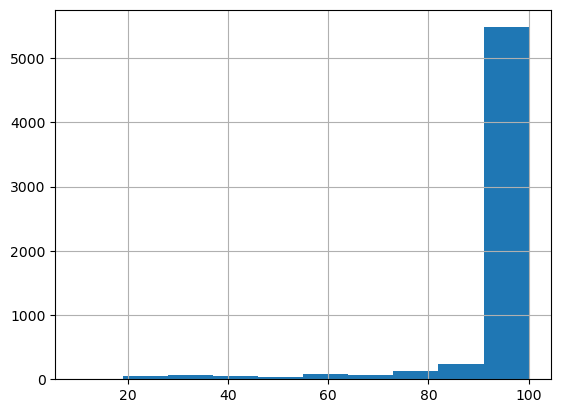

In [61]:
sh2_['battery'].hist()

In [77]:
sh2_.columns

Index(['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime', 'agency', 'site',
       'auto', 'manual', 'anomaly', 'agency_seoul', 'agency2_seong',
       'site_flower', 'site_dgarden', 'site_coffee1', 'site_coffee2',
       'site_rooftop', 'site_spcmplx', 'humi_diff', 'humi_diff_pct',
       'humi_diff_ratio', 'wet_soil', 'normal_soil', 'dry_soil',
       'artificial_soil', 'irr', 'sensingTime_', 'ph_', 'k_temp_', 'k_rain_'],
      dtype='object')

In [86]:
len(sh2_)

6220

In [78]:
sh2_['temp_'] = sh2_['temp'].apply(lambda x: convert_temp(x))

In [79]:
sh2_[sh2_['temp'] > 6000]

,num,sensorName,battery,temp,humi,ph,ec,nitro,phos,pota,...,wet_soil,normal_soil,dry_soil,artificial_soil,irr,sensingTime_,ph_,k_temp_,k_rain_,temp_
24106,24107,STGS71C61000011,100,6554.0,66.4,7.53,0.03,7,9,25,...,1,0,0,0,0,202311110530,7.53,0.0,0.0,0.4
24108,24109,STGS71C61000029,100,6553.0,64.3,7.7,0.00,0,0,0,...,1,0,0,0,0,202311110530,7.70,0.0,0.0,-0.6
24122,24123,STGS71C61000010,90,6554.0,25.6,4.73,0.17,14,19,49,...,0,1,0,0,0,202311110600,4.73,0.0,0.0,0.4
24140,24141,STGS71C61000011,100,6553.0,66.4,7.53,0.03,7,9,25,...,1,0,0,0,0,202311110600,7.53,0.0,0.0,-0.6
24142,24143,STGS71C61000029,100,6553.0,64.3,7.68,0.00,0,0,0,...,1,0,0,0,0,202311110600,7.68,0.0,0.0,-0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27575,27576,STGS71C61000011,100,6553.0,51.0,7.44,0.03,7,9,25,...,1,0,0,0,0,202311190630,7.44,1.0,0.0,-0.6
27577,27578,STGS71C61000029,100,6553.0,71.0,7.21,0.00,0,0,0,...,1,0,0,0,0,202311190630,7.21,1.0,0.0,-0.6
27593,27594,STGS71C61000010,100,6554.0,24.2,4.65,0.12,11,15,40,...,0,1,0,0,0,202311190700,4.65,2.0,0.0,0.4
27611,27612,STGS71C61000011,100,6552.0,50.2,7.42,0.00,0,0,0,...,1,0,0,0,0,202311190700,7.42,1.0,0.0,-1.6


In [88]:
sh2_[['temp','temp_']].iloc[5000:5050]

,temp,temp_
25166,16.8,16.8
25168,13.2,13.2
25171,5.5,5.5
25172,5.9,5.9
25183,4.7,4.7
25184,6.1,6.1
25193,5.6,5.6
25201,5.1,5.1
25203,4.0,4.0
25206,3.7,3.7


In [89]:
sh2_.columns

Index(['num', 'sensorName', 'battery', 'temp', 'humi', 'ph', 'ec', 'nitro',
       'phos', 'pota', 'k_temp', 'k_rain', 'sensingTime', 'agency', 'site',
       'auto', 'manual', 'anomaly', 'agency_seoul', 'agency2_seong',
       'site_flower', 'site_dgarden', 'site_coffee1', 'site_coffee2',
       'site_rooftop', 'site_spcmplx', 'humi_diff', 'humi_diff_pct',
       'humi_diff_ratio', 'wet_soil', 'normal_soil', 'dry_soil',
       'artificial_soil', 'irr', 'sensingTime_', 'ph_', 'k_temp_', 'k_rain_',
       'temp_'],
      dtype='object')

In [90]:
sh2_[['sensingTime','sensingTime_']]

,sensingTime,sensingTime_
1,2023-09-14 04:00,202309140400
13,2023-09-14 04:00,202309140400
14,2023-09-14 04:00,202309140400
32,2023-09-14 04:00,202309140400
34,2023-09-14 04:00,202309140400
...,...,...
28529,2023-11-11 06:00,202311110600
28530,2023-11-11 06:30,202311110630
28531,2023-11-11 07:00,202311110700
28532,2023-11-11 09:00,202311110900


In [92]:
sensor_num_input = 'STGS71C61000004'
sh2_s04 = sh2_[sh2_['sensorName'] == sensor_num_input][['num', 'sensorName', 'battery', 'temp_', 'humi', 'ph_', 'ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime','auto','manual','irr','sensingTime_']]

In [93]:
sh2_s04

,num,sensorName,battery,temp_,humi,ph_,ec,nitro,phos,pota,k_temp_,k_rain_,sensingTime,auto,manual,irr,sensingTime_
1,2,STGS71C61000004,60,20.1,53.9,7.03,0.00,0,0,0,20.0,0.0,2023-09-14 04:00,0,0,0,202309140400
38,39,STGS71C61000004,60,19.7,53.4,6.94,0.00,0,0,0,20.0,0.0,2023-09-14 05:00,0,0,0,202309140500
75,76,STGS71C61000004,60,19.8,53.1,6.91,0.00,0,0,0,20.0,0.0,2023-09-14 05:30,0,0,0,202309140530
111,112,STGS71C61000004,60,19.5,52.7,6.83,0.00,0,0,0,20.0,0.0,2023-09-14 06:00,0,0,0,202309140600
148,149,STGS71C61000004,60,19.4,52.7,6.76,0.00,0,0,0,20.0,0.0,2023-09-14 06:30,0,0,0,202309140630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27654,27655,STGS71C61000004,100,8.1,27.3,5.01,0.11,11,14,37,9.0,0.0,2023-11-19 11:00,0,0,0,202311191100
27690,27691,STGS71C61000004,100,11.3,27.5,5.22,0.11,11,15,38,14.0,0.0,2023-11-19 13:00,0,0,0,202311191300
27726,27727,STGS71C61000004,100,13.9,27.5,5.38,0.12,11,15,39,13.0,0.0,2023-11-19 15:00,0,0,0,202311191500
27762,27763,STGS71C61000004,100,9.1,27.1,5.29,0.11,11,15,38,12.0,0.0,2023-11-19 17:00,0,0,0,202311191700


In [119]:
#sh2_s04.drop(['battery_log'],axis=1,inplace=True)

In [120]:
sh2_s04_['bat_log'] = sh2_s04_['battery'].apply(lambda x : log_transform(x))

In [125]:
sh2_s04_['ph_recip'] = sh2_s04_['ph_'].apply(lambda x : recip_transform(x))

In [128]:
sh2_s04_['ph_sqrt'] = sh2_s04_['ph_'].apply(lambda x : sqrt_transform(x))
sh2_s04_['ph_cbrt'] = sh2_s04_['ph_'].apply(lambda x : cbrt_transform(x))

In [141]:
#sh2_s04_['ph_bxcx'] = sh2_s04_['ph_'].apply(lambda x : bxcx_transform(x))
#sh2_s04_['ph_bxcx'] = np.apply_along_axis(bxcx_transform2, axis=0, arr=sh2_s04_['ph_'].values.reshape(1, -1)).flatten()

In [142]:
sh2_s04_['k_temp_yj'] = yj_transform(sh2_s04_['k_temp_'])

In [146]:
sh2_s04_['k_rain_sqrt'] = sqrt_transform(sh2_s04_['k_rain_'])

In [148]:
sh2_s04_['k_rain_cbrt'] = cbrt_transform(sh2_s04_['k_rain_'])
sh2_s04_['k_rain_recip'] = recip_transform(sh2_s04_['k_rain_'])

In [149]:
sh2_s04_['k_rain_bxcx'] = bxcx_transform2(sh2_s04_['k_rain_'])
sh2_s04_['k_rain_yj'] = yj_transform(sh2_s04_['k_rain_'])

In [154]:
sh2_s04_['k_rain_log'] = log_transform(sh2_s04_['k_rain_'])

In [ ]:
# battery -> right(100) concentrated // do logarithmic transform; log(x+1) and standard scaling 
# log transform chosen

# temp_ -> standard scaling
# humi -> standard scaling (?)

# ph_ ; a transformation needed ? a reversed bell-shaped curve // 1. square root 2. cube root 3. reciprocal 4. box-cox
# ph_ ; go try the recip.

# ec -> standard scaling
# nitro -> standard scaling
# phos -> standard scaling
# pota -> standard scaling

# k_temp_ ; a transformation needed ? a mixture of bell curves(m shaped) // 1. log transform 2. sqrt 3. bxcx 4. Yeo-Johnson transform
# yj chosen
# k_rain_ ; a transformation needed ? left(0) concentrated  // 1. square root 2. cube root
# no transform ? before standard scaling 

In [156]:
sh2_s04_.columns

Index(['num', 'sensorName', 'battery', 'temp_', 'humi', 'ph_', 'ec', 'nitro',
       'phos', 'pota', 'k_temp_', 'k_rain_', 'sensingTime', 'auto', 'manual',
       'irr', 'sensingTime_', 'bat_log', 'ph_recip', 'ph_sqrt', 'ph_cbrt',
       'k_temp_yj', 'k_rain_sqrt', 'k_rain_cbrt', 'k_rain_recip',
       'k_rain_bxcx', 'k_rain_yj', 'k_rain_log'],
      dtype='object')

In [158]:
len(['bat_log','temp_','humi','ph_recip','ec','nitro','phos','pota','k_temp_yj','k_rain','sensingTime_'])

11

In [161]:
sh2_s04_[['bat_log','temp_','humi','ph_recip','ec','nitro','phos','pota','k_temp_yj','k_rain_','sensingTime_']]

,bat_log,temp_,humi,ph_recip,ec,nitro,phos,pota,k_temp_yj,k_rain_,sensingTime_
1,4.110874,20.1,53.9,0.124533,0.00,0,0,0,43.518287,0.0,202309140400
38,4.110874,19.7,53.4,0.125945,0.00,0,0,0,43.518287,0.0,202309140500
75,4.110874,19.8,53.1,0.126422,0.00,0,0,0,43.518287,0.0,202309140530
111,4.110874,19.5,52.7,0.127714,0.00,0,0,0,43.518287,0.0,202309140600
148,4.110874,19.4,52.7,0.128866,0.00,0,0,0,43.518287,0.0,202309140630
...,...,...,...,...,...,...,...,...,...,...,...
27654,4.615121,8.1,27.3,0.166389,0.11,11,14,37,15.616239,0.0,202311191100
27690,4.615121,11.3,27.5,0.160772,0.11,11,15,38,27.440605,0.0,202311191300
27726,4.615121,13.9,27.5,0.156740,0.12,11,15,39,24.949164,0.0,202311191500
27762,4.615121,9.1,27.1,0.158983,0.11,11,15,38,22.517782,0.0,202311191700


In [162]:
sh2_s04_of_interest = sh2_s04_[['bat_log','temp_','humi','ph_recip','ec','nitro','phos','pota','k_temp_yj','k_rain_','sensingTime_']]

In [175]:
sh2_s04_['irr'].value_counts()

irr
0    625
1      2
Name: count, dtype: int64

In [167]:
target_cols = ['bat_log','temp_','humi','ph_recip','ec','nitro','phos','pota','k_temp_yj','k_rain_','sensingTime_']

In [163]:
scaler = StandardScaler()

In [171]:
### Standardization ###
standardization(sh2_s04_of_interest,target_cols)

In [173]:
sh2_s04_of_interest.columns

Index(['bat_log', 'temp_', 'humi', 'ph_recip', 'ec', 'nitro', 'phos', 'pota',
       'k_temp_yj', 'k_rain_', 'sensingTime_', 'bat_log(scaled)',
       'temp_(scaled)', 'humi(scaled)', 'ph_recip(scaled)', 'ec(scaled)',
       'nitro(scaled)', 'phos(scaled)', 'pota(scaled)', 'k_temp_yj(scaled)',
       'k_rain_(scaled)', 'sensingTime_(scaled)'],
      dtype='object')

In [176]:
X = sh2_s04_of_interest[['bat_log(scaled)','temp_(scaled)', 'humi(scaled)', 'ph_recip(scaled)', 'ec(scaled)','nitro(scaled)', 
     'phos(scaled)', 'pota(scaled)', 'k_temp_yj(scaled)','k_rain_(scaled)', 'sensingTime_(scaled)']]
y = sh2_s04_[['irr']]

In [189]:
##AttributeError: 'int' object has no attribute 'fit'
y = y.astype(float)

In [187]:
X.dtypes

bat_log(scaled)         float64
temp_(scaled)           float64
humi(scaled)            float64
ph_recip(scaled)        float64
ec(scaled)              float64
nitro(scaled)           float64
phos(scaled)            float64
pota(scaled)            float64
k_temp_yj(scaled)       float64
k_rain_(scaled)         float64
sensingTime_(scaled)    float64
dtype: object

In [192]:
y.dtypes

irr    float64
dtype: object

In [204]:
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [209]:
# Use the stratify parameter in the train_test_split function to ensure that the class distribution is preserved in both the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [179]:
### old models that I used for regression problems ###
# # ordinary linear regression model
# line_fitter = LinearRegression()
# ### turned models through series of parameter adjustments
# # linear models
# ridge_fitter = Ridge()
# lasso_fitter = Lasso()
# elasticNet_fitter = ElasticNet()
# # ensemble models
# xgb_fitter = XGBRegressor()
# gbm_fitter = GradientBoostingRegressor()
# rf_fitter = RandomForestRegressor()
# lgbm_fitter = LGBMRegressor()
# bg_fitter = BaggingRegressor()
# et_fitter = ExtraTreesRegressor()
# ---------------------------------------
# Ridge, Lasso, and Elastic Net are regularization methods and not directly transferable to classification.
# RidgeClassifierCV, LassoCV, and ElasticNetCV can be used for classification, but they are different from the regression counterparts.

In [181]:
# Logistic classifier
logistic_classifier = LogisticRegression()
# Linear SVC
linear_svc_classifier = SVC(kernel = 'linear', probability=True)
rbf_svc_classifier = SVC(kernel = 'rbf', probability=True)
# Ensemble Models
random_forest_classifier = RandomForestClassifier()
gradient_boosting_classifier = GradientBoostingClassifier()
bagging_classifier = BaggingClassifier()
extra_trees_classifier = ExtraTreesClassifier()
xgb_classifier = XGBClassifier()
lgbm_classifier = LGBMClassifier()

In [184]:
model_lst = [logistic_classifier,linear_svc_classifier,rbf_svc_classifier,random_forest_classifier,gradient_boosting_classifier,bagging_classifier,extra_trees_classifier,xgb_classifier,lgbm_classifier]

In [185]:
len(model_lst)

9

In [219]:
# for model in model_lst:
#     print_classification_metrics(model, X_train, X_test, y_train, y_test)

In [197]:
unique_classes_y_train = np.unique(y_train)
unique_classes_y_test = np.unique(y_test)

print("Unique Classes in y_train:", unique_classes_y_train)
print("Unique Classes in y_test:", unique_classes_y_test)

Unique Classes in y_train: [0. 1.]
Unique Classes in y_test: [0.]


In [199]:
#print("Distribution of classes in y_train:", np.bincount(y_train))
#print("Distribution of classes in y_test:", np.bincount(y_test))

In [200]:
print("Data type of y_train:", type(y_train))
print("Data type of y_test:", type(y_test))

Data type of y_train: <class 'pandas.core.frame.DataFrame'>
Data type of y_test: <class 'pandas.core.frame.DataFrame'>


In [202]:
# # Assuming your target variable is stored in a column named 'target_column'
# y_train_array = y_train['irr'].to_numpy()
# y_test_array = y_test['irr'].to_numpy()

# # Alternatively, if 'target_column' is the index, you can use
# # y_train_array = y_train.index.to_numpy()
# # y_test_array = y_test.index.to_numpy()

# # Check the data types again
# print("Data type of y_train_array:", type(y_train_array))
# print("Data type of y_test_array:", type(y_test_array))

# # Check the distribution of classes
# print("Distribution of classes in y_train_array:", np.bincount(y_train_array))
# print("Distribution of classes in y_test_array:", np.bincount(y_test_array))

In [203]:
# Assuming your target variable is stored in a column named 'irr'
y_train_counts = y_train['irr'].value_counts()
y_test_counts = y_test['irr'].value_counts()

# Display the distribution of unique values
print("Distribution of classes in y_train:")
print(y_train_counts)

print("\nDistribution of classes in y_test:")
print(y_test_counts)

Distribution of classes in y_train:
irr
0.0    499
1.0      2
Name: count, dtype: int64

Distribution of classes in y_test:
irr
0.0    126
Name: count, dtype: int64


In [210]:
# Assuming your target variable is stored in a column named 'irr'
y_train_counts = y_train['irr'].value_counts()
y_test_counts = y_test['irr'].value_counts()

# Display the distribution of unique values
print("Distribution of classes in y_train:")
print(y_train_counts)

print("\nDistribution of classes in y_test:")
print(y_test_counts)

Distribution of classes in y_train:
irr
0.0    499
1.0      2
Name: count, dtype: int64

Distribution of classes in y_test:
irr
0.0    126
Name: count, dtype: int64


In [211]:
print("Distribution of classes in original y:")
print(y['irr'].value_counts())

Distribution of classes in original y:
irr
0.0    625
1.0      2
Name: count, dtype: int64


In [216]:
X_resampled, y_resampled = SMOTE(k_neighbors=1, random_state=42).fit_resample(X,y)

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [218]:
# Assuming your target variable is stored in a column named 'irr'
y_train_counts = y_train['irr'].value_counts()
y_test_counts = y_test['irr'].value_counts()

# Display the distribution of unique values
print("Distribution of classes in y_train:")
print(y_train_counts)

print("\nDistribution of classes in y_test:")
print(y_test_counts)

Distribution of classes in y_train:
irr
1.0    514
0.0    486
Name: count, dtype: int64

Distribution of classes in y_test:
irr
0.0    139
1.0    111
Name: count, dtype: int64


In [220]:
for model in model_lst:
    print_classification_metrics(model, X_train, X_test, y_train, y_test)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for examp

##### LogisticRegression #####
Accuracy: 1.0000
AUC Score: 1.0000
Log Loss: 0.0108
##### SVC #####
Accuracy: 1.0000
AUC Score: 1.0000
Log Loss: 0.0034
##### SVC #####
Accuracy: 1.0000
AUC Score: 1.0000
Log Loss: 0.0024
##### RandomForestClassifier #####
Accuracy: 0.9960
AUC Score: 1.0000
Log Loss: 0.0036
##### GradientBoostingClassifier #####
Accuracy: 0.9960
AUC Score: 1.0000
Log Loss: 0.0056
##### BaggingClassifier #####
Accuracy: 0.9960
AUC Score: 1.0000
Log Loss: 0.0032
##### ExtraTreesClassifier #####
Accuracy: 1.0000
AUC Score: 1.0000
Log Loss: 0.0003
##### XGBClassifier #####
Accuracy: 0.9960
AUC Score: 1.0000
Log Loss: 0.0056
[LightGBM] [Info] Number of positive: 514, number of negative: 486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2140
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 10
[Li

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_s

<Axes: >

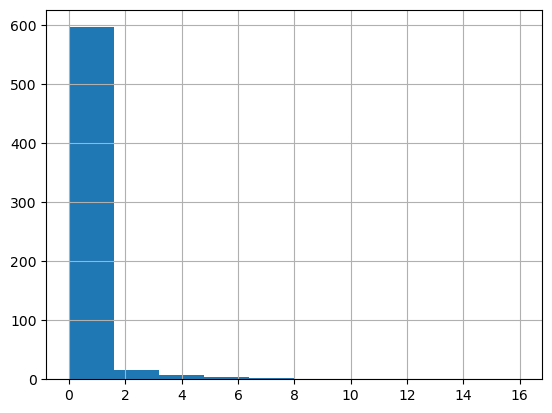

In [145]:
sh2_s04_['k_rain_'].hist()

<Axes: >

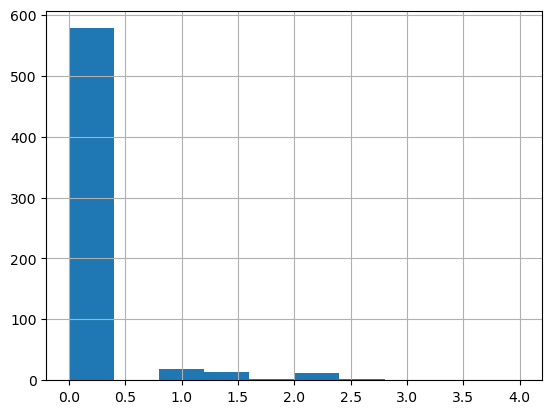

In [147]:
sh2_s04_['k_rain_sqrt'].hist()

<Axes: >

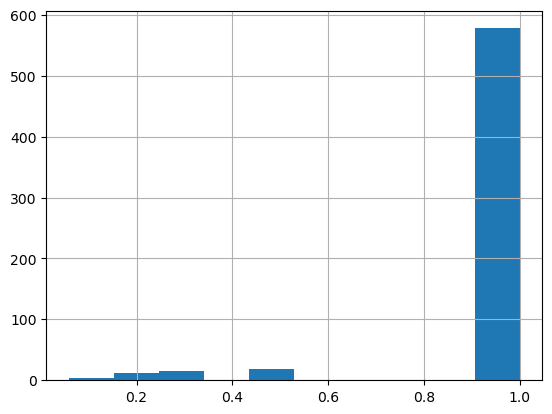

In [153]:
sh2_s04_['k_rain_recip'].hist()

<Axes: >

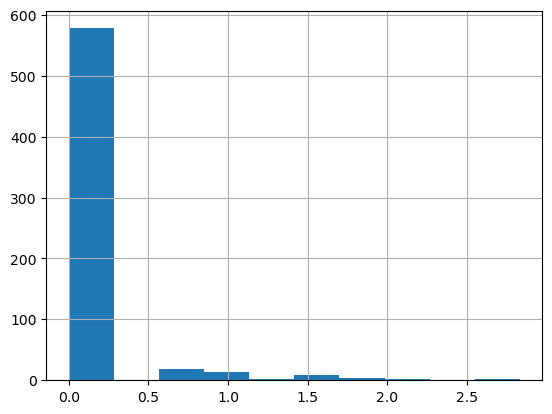

In [155]:
sh2_s04_['k_rain_log'].hist()

<Axes: >

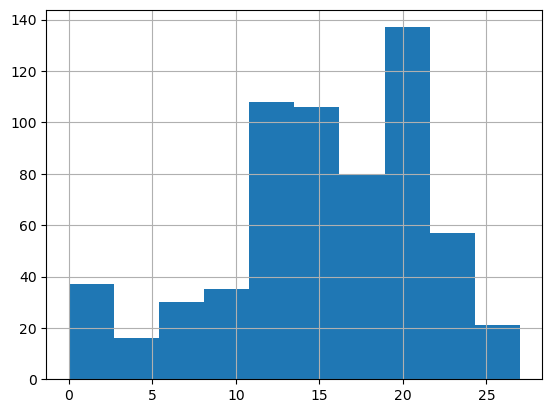

In [143]:
sh2_s04_['k_temp_'].hist()

<Axes: >

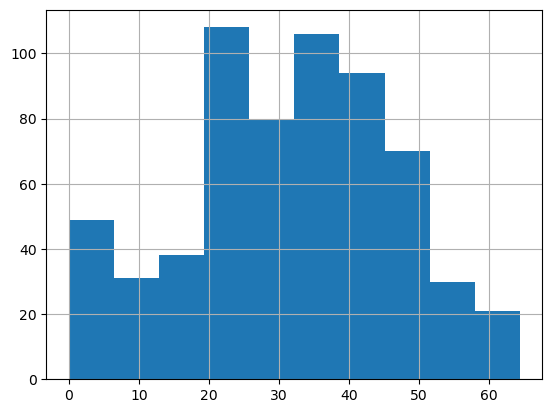

In [144]:
sh2_s04_['k_temp_yj'].hist()

In [112]:
sh2_s04['k_rain_'].value_counts()

k_rain_
0.0     580
1.0      18
2.0      13
4.0       8
5.0       4
7.0       2
3.0       2
12.0      1
16.0      1
Name: count, dtype: int64

In [101]:
sh2_s04[sh2_s04['nitro'] > 700]

,num,sensorName,battery,temp_,humi,ph_,ec,nitro,phos,pota,k_temp_,k_rain_,sensingTime,auto,manual,irr,sensingTime_
2826,2827,STGS71C61000004,10,25.6,78.6,6.00,0.2,742,15,21,24.0,0.0,2023-09-20 01:00,0,0,0,202309200100
9867,9868,STGS71C61000004,100,12.7,25.5,8.05,0.1,788,10,14,12.0,0.0,2023-10-05 05:30,0,0,0,202310050530


In [104]:
sh2_s04_ = sh2_s04[sh2_s04['nitro'] < 700]

In [105]:
len(sh2_s04), len(sh2_s04_)

(629, 627)